#$\bf{f(t) = a_0 + \sum_{n=1}^{\infty} a_n cos(\frac{2n\pi t}{T}) + \sum_{n=1}^{\infty} b_n sin(\frac{2n\pi t}{T})}$


In [1]:
import pandas as pd
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 18})
plt.style.use('seaborn')



# statics

In [2]:
#startdatum = "2016-01-01"
#enddatum = "2019-10-10"

custom_date_parser = lambda x: datetime.strptime(x, "%Y-%m-%d")

mypath = "C:/Users/Schroeder/OneDrive/Trading/ETFS/Analyse_data/"
df = pd.read_csv(mypath + "fft_holc_data.csv",sep=";",decimal=',',
                            parse_dates=True,date_parser=custom_date_parser,
                            index_col=0)



<AxesSubplot:xlabel='Date'>

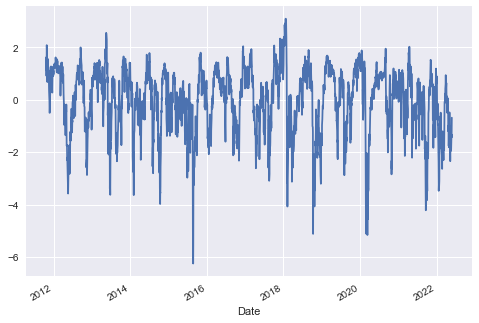

In [3]:
df=df.sort_index()
#df=df.truncate(before=startdatum)
#df=df.truncate(after=enddatum)

target_column = "z-score"

df
df.index[:-1]
df[target_column].plot()

In [4]:

df_np =df[target_column].to_numpy()
signal = df_np
print(type(df_np))
#remove NaNs
nan_array = np.isnan(signal)
not_nan_array = ~ nan_array
signal = signal[not_nan_array]
signal_clean = signal

minsignal, maxsignal = signal.min(), signal.max()
print(maxsignal)

<class 'numpy.ndarray'>
3.09143


## Compute Fourier Transform

In [5]:
n = len(signal)
dt = 1.0/n
t = np.arange(0, 1, dt)

fhat = np.fft.fft(signal, n) #computes the fft
psd = fhat * np.conj(fhat)/n
freq =  np.arange(n) #frequency array
#freq = (1/(dt*n)) * np.arange(n) #frequency array
idxs_half = np.arange(1, np.floor(n/2), dtype=np.int32) #first half index
len(t)

2668

## Filter out noise

In [10]:
threshold = 80
psd_idxs = psd != 16# threshold #array of 0 and 1
psd_idxs2 = psd > threshold
psd_idxs=psd_idxs*psd_idxs2

psd_clean = psd * psd_idxs #zero out all the unnecessary powers
fhat_clean = psd_idxs * fhat #used to retrieve the signal

signal_filtered = np.fft.ifft(fhat_clean) #inverse fourier transform

## Visualization

C:\Users\Schroeder\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


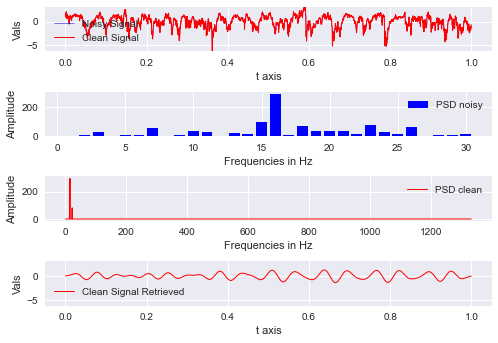

In [11]:
freqmax = 30
maxamp = 2000

psd = np.clip(psd,0,maxamp)

fig, ax = plt.subplots(4,1)
ax[0].plot(t, signal, color='b', lw=0.5, label='Noisy Signal')
ax[0].plot(t, signal_clean, color='r', lw=1, label='Clean Signal')
ax[0].set_ylim([minsignal, maxsignal])
ax[0].set_xlabel('t axis')
ax[0].set_ylabel('Vals')
ax[0].legend()

ax[1].bar(freq[idxs_half][:freqmax], np.abs(psd[idxs_half][:freqmax]), color='b', lw=0.5, label='PSD noisy')
ax[1].set_xlabel('Frequencies in Hz')
ax[1].set_ylabel('Amplitude')
ax[1].legend()

ax[2].plot(freq[idxs_half], np.abs(psd_clean[idxs_half]), color='r', lw=1, label='PSD clean')
ax[2].set_xlabel('Frequencies in Hz')
ax[2].set_ylabel('Amplitude')
ax[2].legend()

ax[3].plot(t, signal_filtered, color='r', lw=1, label='Clean Signal Retrieved')
ax[3].set_ylim([minsignal, maxsignal])
ax[3].set_xlabel('t axis')
ax[3].set_ylabel('Vals')
ax[3].legend()



plt.subplots_adjust(hspace=0.9)
plt.savefig('signal-analysis.png', bbox_inches='tight', dpi=300)
